In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
import torch
import sys
import pickle

In [2]:
site = 'C'

In [25]:
# get parent directory
os.chdir("..")

# import file
from network import Net
from evaluation import eval_prediction, eval_PI, PItrend, plot_PItrend, pivot, plot_heatmap, plot_time, plot_2pcurve, plot_res, plot_reshistogram, plot_pcurve, plot_res_vs_var

# get higher level parent directory
os.chdir("..")


directory = 'Data_clean'
data_name = site + '_data_clean.csv'
scaler_nameX = site + "_scalerX.pkl"
scaler_nameY = site + "_scalerY.pkl"

# load all data and scaler functions 
data = pd.read_csv(os.path.join(os.getcwd(), directory, data_name), index_col = 0)
scalerX = pickle.load(open(os.path.join(os.getcwd(), directory, scaler_nameX),'rb'))
scalerY = pickle.load(open(os.path.join(os.getcwd(), directory, scaler_nameY),'rb'))

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [4]:
data

,ts,Month,Day,Hour,instanceID,Wind_speed,TI,Temperature,Power
1,2020-01-01 00:00:00,1,1,0,C_WTG02,4.062859,11.707602,4.273333,144.951967
3,2020-01-01 00:00:00,1,1,0,C_WTG04,4.695373,15.176091,5.270000,160.230282
4,2020-01-01 00:00:00,1,1,0,C_WTG05,3.614577,15.750575,5.451667,64.632802
5,2020-01-01 00:00:00,1,1,0,C_WTG06,3.526409,19.338555,5.393333,65.132216
6,2020-01-01 00:00:00,1,1,0,C_WTG07,4.067837,15.708470,5.593333,100.370317
...,...,...,...,...,...,...,...,...,...
1106799,2021-01-01 00:00:00,1,1,0,C_WTG16,7.277958,8.877151,3.032759,800.435183
1106800,2021-01-01 00:00:00,1,1,0,C_WTG17,3.293306,24.411169,3.100000,99.137754
1106802,2021-01-01 00:00:00,1,1,0,C_WTG19,6.826774,11.834653,2.510345,680.744135
1106803,2021-01-01 00:00:00,1,1,0,C_WTG20,6.148926,12.236465,3.451724,542.628140


In [5]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'TI',
       'Temperature', 'Power'])

### Predict

In [6]:
# load the trained weights
checkpoint_median = torch.load(sys.path[0] + '/median.pth')
checkpoint_UQ = torch.load(sys.path[0] + '/UQ.pth')
checkpoint_LQ = torch.load(sys.path[0] + '/LQ.pth')

# initialize network
net_median = Net(dims = (3, 16, 16, 16, 16, 1))
net_UQ = Net(dims = (3, 16, 16, 16, 16, 1))
net_LQ = Net(dims = (3, 16, 16, 16, 16, 1))

In [7]:
%%time
# prediction
# create a list of turbine IDs
turbines = data.instanceID.unique()
# create an empty dataframe to store the results
results = pd.DataFrame

# loop over each turbine
for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # normalize data
    X = data_temp.iloc[:, 6:-1].values
    X = scalerX.transform(X)
    
    # load network parameters based on turbine number
    net_median.load_state_dict(checkpoint_median[ID])
    net_UQ.load_state_dict(checkpoint_UQ[ID])
    net_LQ.load_state_dict(checkpoint_LQ[ID])

    # a forward pass through the network to predict the output
    # predict the median, upper quantile, and lower quantile
    median = net_median(Tensor(X))
    median = scalerY.inverse_transform(median.detach().numpy()).flatten()
    UQ = net_UQ(Tensor(X))
    UQ = scalerY.inverse_transform(UQ.detach().numpy()).flatten()
    LQ = net_LQ(Tensor(X))
    LQ = scalerY.inverse_transform(LQ.detach().numpy()).flatten()

    # concatenate results by column
    data_temp = pd.concat([data_temp, pd.Series(median, index = data_temp.index.values, name = 'Predicted_power'), 
                           pd.Series(UQ, index = data_temp.index.values, name = 'UQ'), 
                           pd.Series(LQ, index = data_temp.index.values, name = 'LQ')], axis = 1)
    
    # concatenate results by row
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 2.43 s


In [8]:
results.head()

,ts,Month,Day,Hour,Week,instanceID,Wind_speed,TI,Temperature,Power,Predicted_power,UQ,LQ
1,2020-01-01 00:00:00,1,1,0,1,C_WTG02,4.062859,11.707602,4.273333,144.951967,127.645348,197.708328,93.651817
22,2020-01-01 00:10:00,1,1,0,1,C_WTG02,4.846914,14.856238,4.400000,241.911755,269.389709,355.722412,208.612076
43,2020-01-01 00:20:00,1,1,0,1,C_WTG02,4.945137,11.742346,4.470000,252.295768,273.913239,369.579102,216.906937
64,2020-01-01 00:30:00,1,1,0,1,C_WTG02,5.251834,10.815515,4.516667,287.445673,335.645111,451.670929,261.346283
85,2020-01-01 00:40:00,1,1,0,1,C_WTG02,5.313850,10.067187,4.612069,340.274619,345.759186,467.660248,269.909943


In [9]:
# create dataframe for the results
# calculate the width of prediction interval
results_all = results.assign(PI_width = results['UQ'] - results['LQ'])
# calculate the error (= residual)
results_all = results_all.assign(Error = results_all['Predicted_power'] - results_all['Power'])

# classify outlier 
results_all['Outlier_pred'] = (results_all['Power'] < results_all['LQ']) | (results_all['Power'] > results_all['UQ'])
results_all['Under_pred'] = (results_all['Power'] < results_all['LQ'])
results_all['Over_pred'] = (results_all['Power'] > results_all['UQ'])
results_all['Sample_count'] = 1

### Performance

In [10]:
# compute and print the performance of prediction 
RMSE, MAE = eval_prediction(results_all)
print('The root mean square error (RMSE) is', RMSE)
print('The mean absolute error (MAE) is', MAE)

The root mean square error (RMSE) is 55.01970578772131
The mean absolute error (MAE) is 37.96274738793551


In [11]:
# compute and print the performance of prediction interval 
# PICP - prediction interval coverage probability 
# NMPIW - normalized mean prediction interval width 
# CWC - coverage width base criterion
# we want PICP near 0.95, narrow NMPIW, and low CWC

PICP, NMPIW, CWC = eval_PI(results_all)
print('We are predicting a 95% confidence PI. We want the coverage to be as close as 95%. We have:')
print('The prediction interval coverage probability (PICP) is', round(PICP*100, 2),'%.')
print('The normalized mean PI width (NMPIW) is', round(NMPIW, 4))
print('The coverage width-based criterion (CWC) is', round(CWC, 4))

We are predicting a 95% confidence PI. We want the coverage to be as close as 95%. We have:
The prediction interval coverage probability (PICP) is 94.48 %.
The normalized mean PI width (NMPIW) is 0.0904
The coverage width-based criterion (CWC) is 0.1803


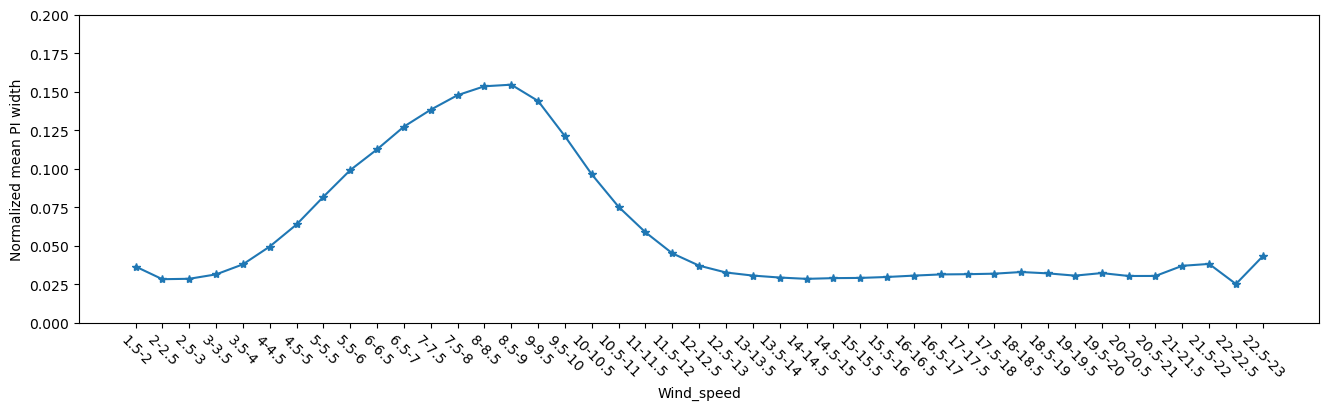

In [13]:
# plot the trend of wind speed vs NMPIW
df_trend = PItrend("Wind_speed", results_all)
plot_PItrend("Wind_speed", df_trend)

### Examine the residuals

In [23]:
# select a turbine
temp_data = results_all[results_all['instanceID'] == site + '_WTG05']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

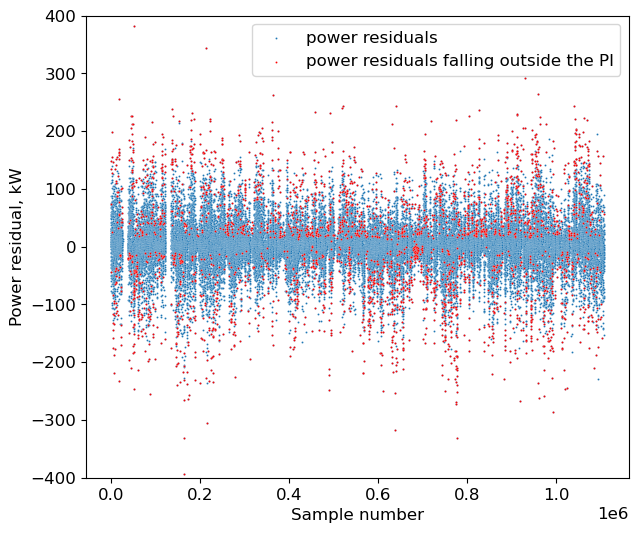

In [31]:
# plot the residuals
plot_res(temp_data, temp_outlier, ylim = 400, outlier = True)

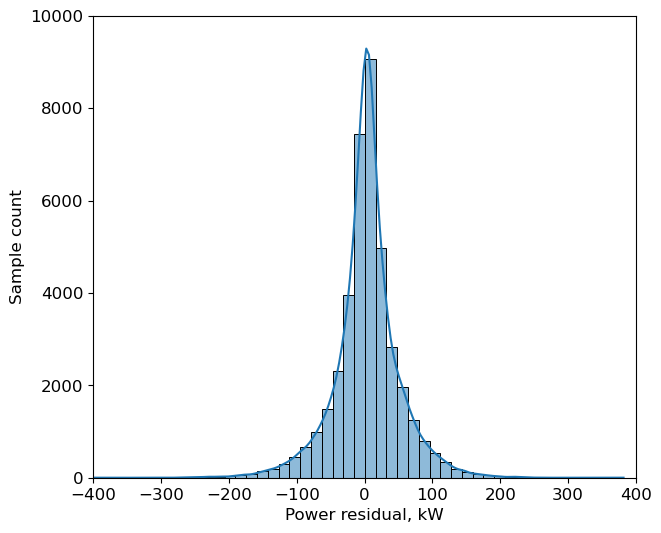

In [24]:
# plot the histogram of the residuals
plot_reshistogram(temp_data, xlim = 400, ylim = 10000)

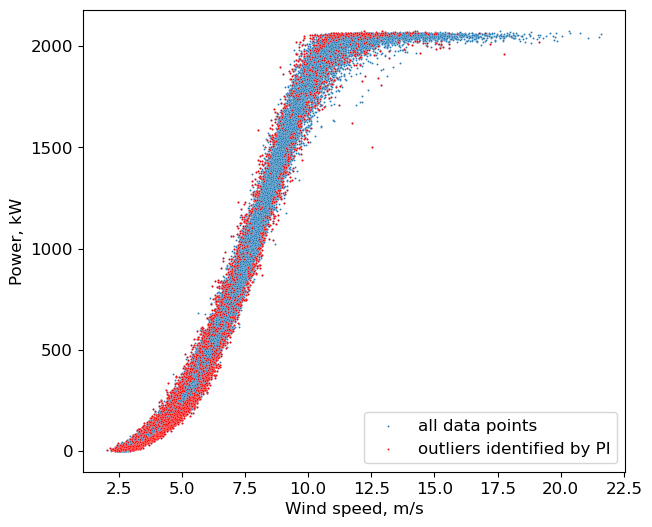

In [27]:
# plot the power curve 
plot_pcurve(temp_data, temp_outlier, outlier = True)

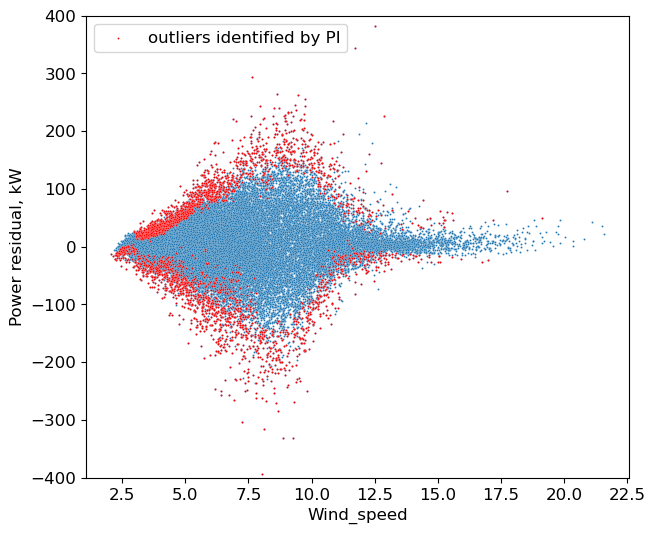

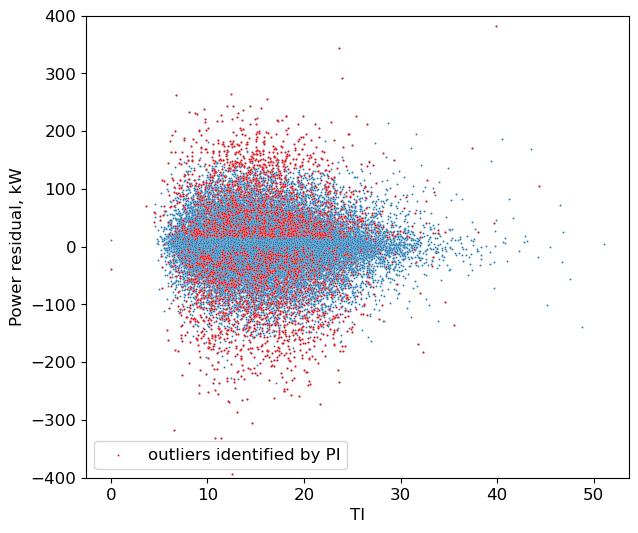

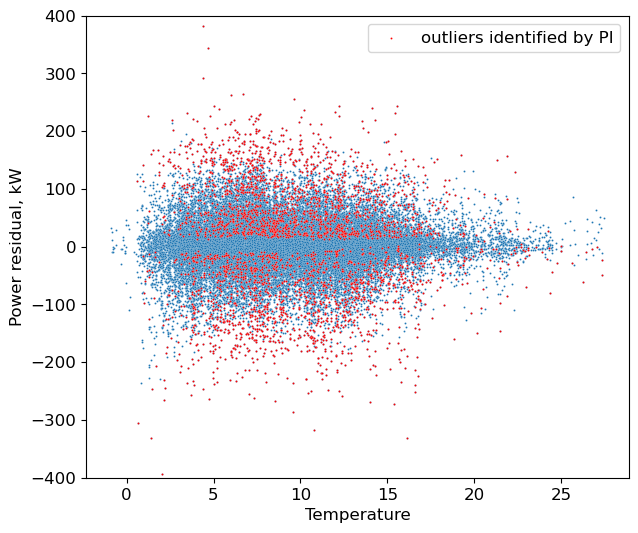

In [33]:
# plot the residuals vs wind speed/TI/temperature
# note: heteroscedasticity
plot_res_vs_var(temp_data, temp_outlier, "Wind_speed", ylim = 400, outlier = True)
plot_res_vs_var(temp_data, temp_outlier, "TI", ylim = 400, outlier = True)
plot_res_vs_var(temp_data, temp_outlier, "Temperature", ylim = 400, outlier = True)

### Create pivot and heatmap

In [ ]:
# define threshold
L0_threshold = 0.1
L1_threshold = 0.2
L2_threshold = 0.3

In [ ]:
cat_1 = "Outliers above UQ & below LQ"
cat_2 = "Outliers above UQ"
cat_3 = "Outliers below LQ"

In [ ]:
df_pivot_cat_1, df_pivot_cat_2, df_pivot_cat_3 = pivot(results_all, L0_threshold, L1_threshold, L2_threshold)

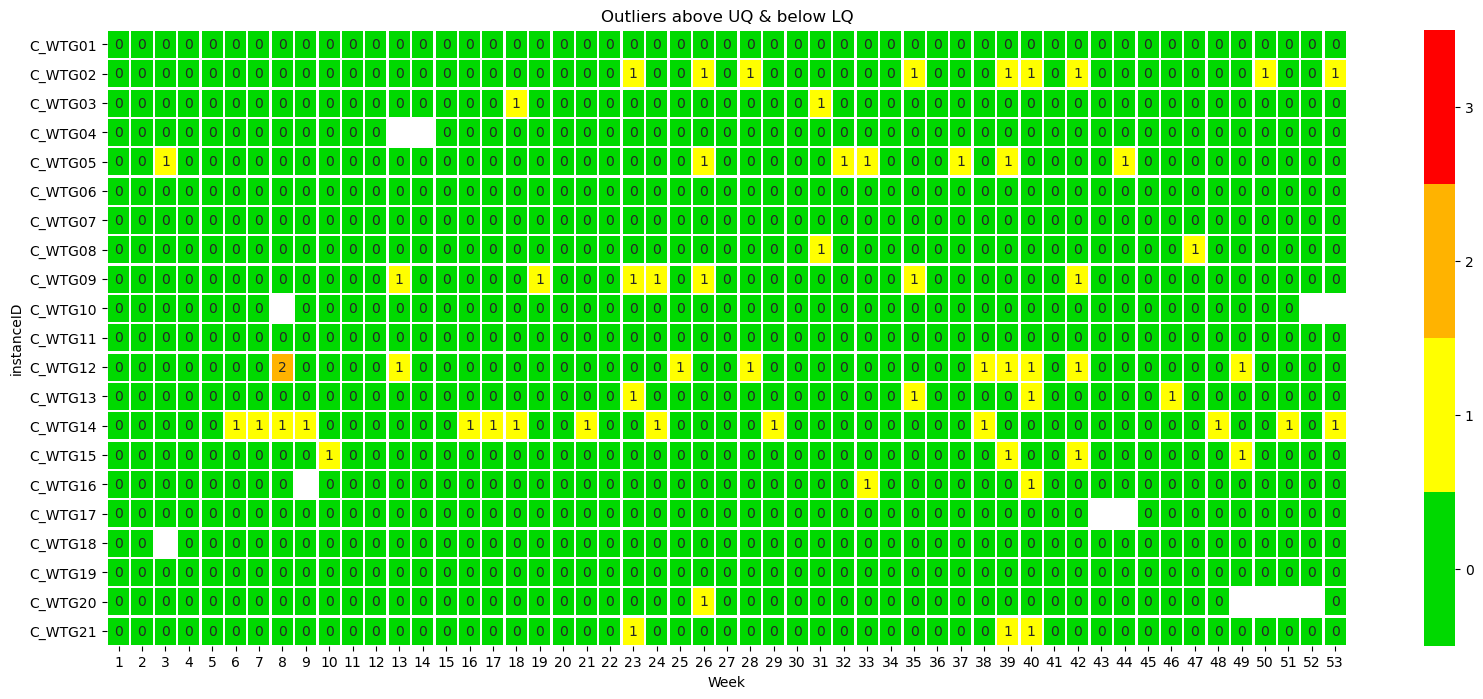

In [ ]:
plot_heatmap(df_pivot_cat_1, cat_1)

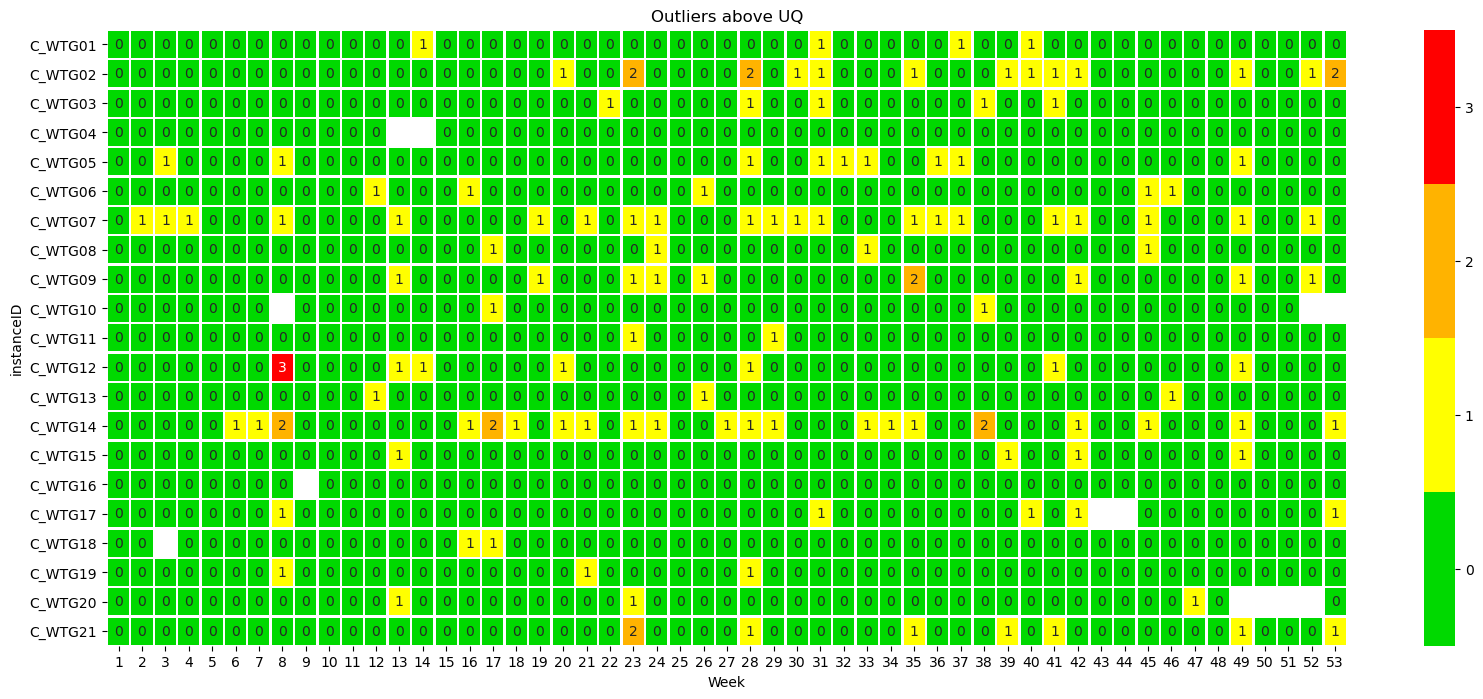

In [ ]:
plot_heatmap(df_pivot_cat_2, cat_2)

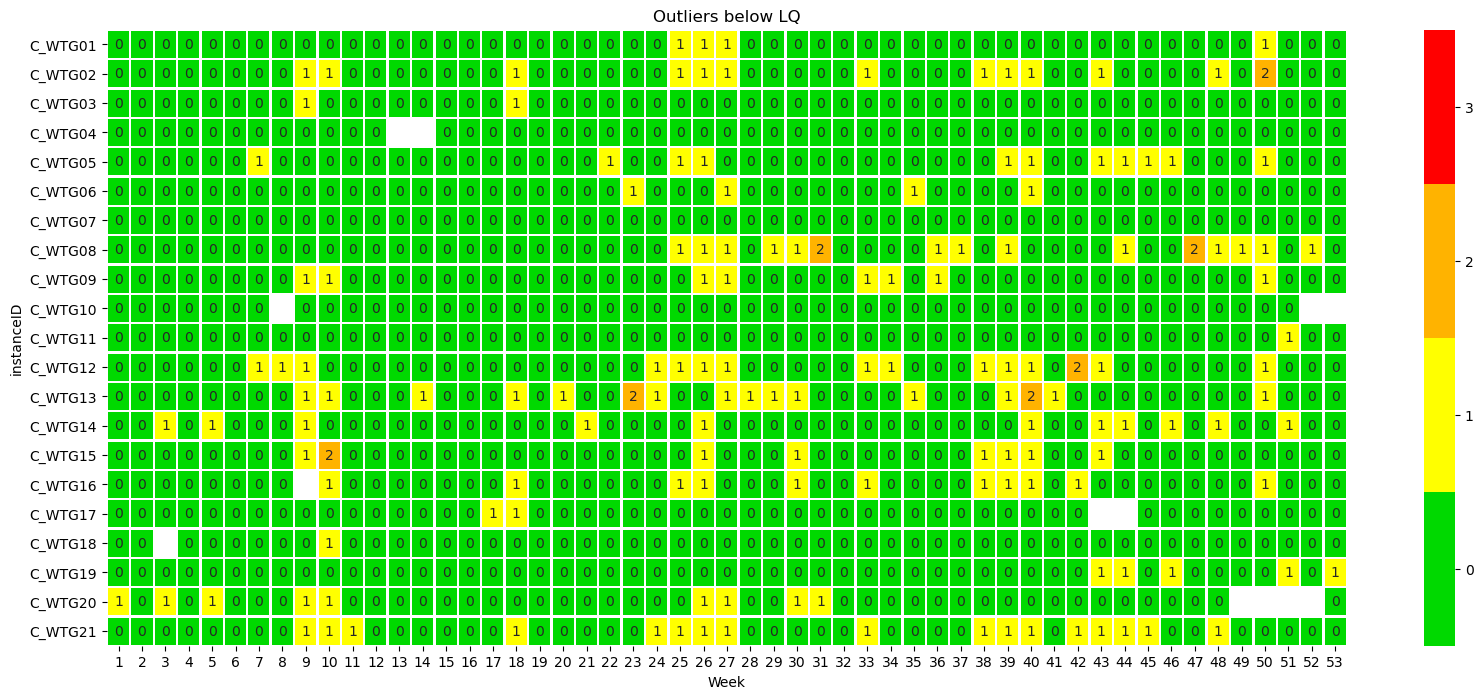

In [ ]:
plot_heatmap(df_pivot_cat_3, cat_3)

### Plots 

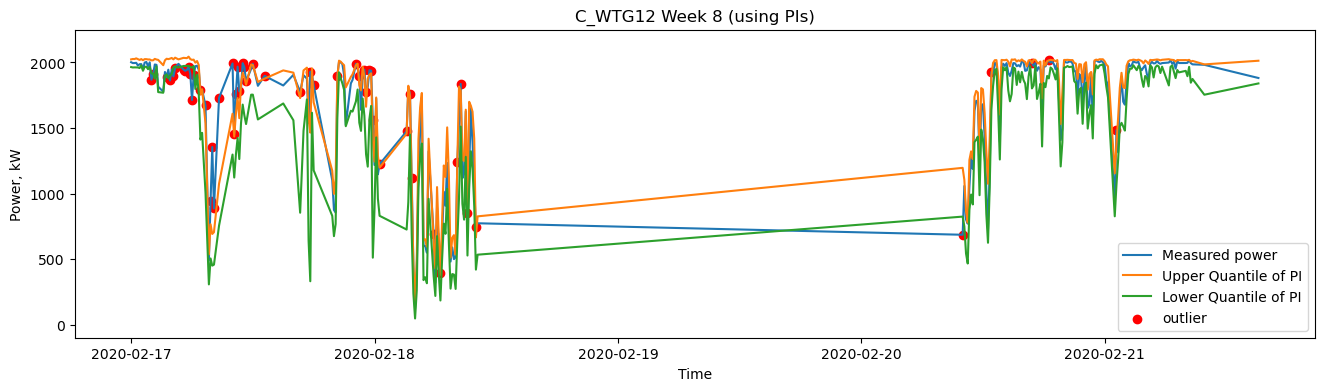

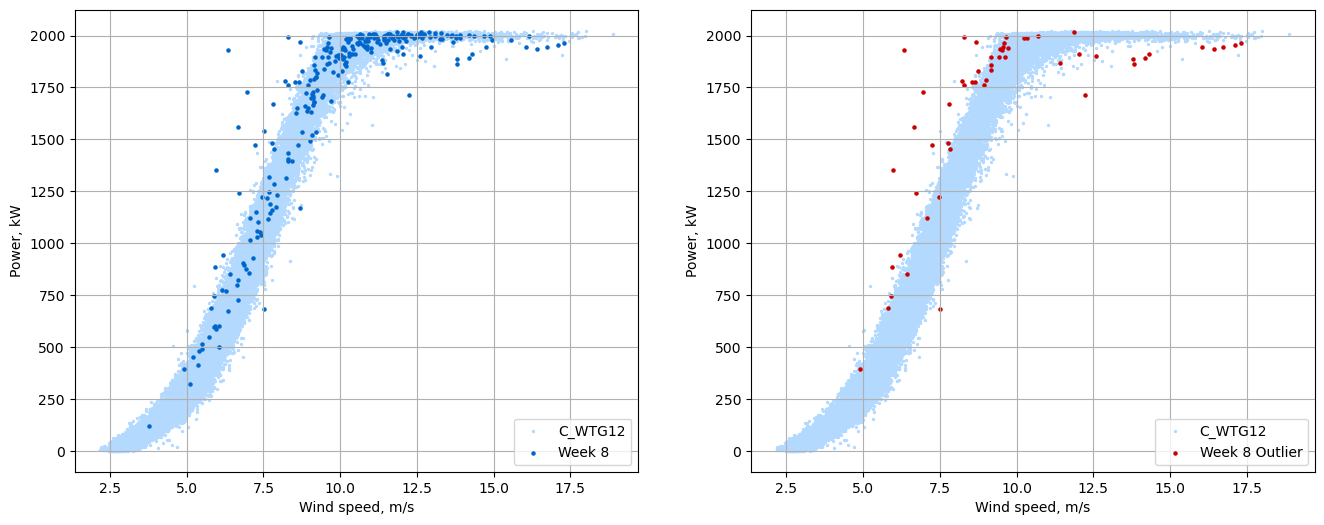

In [ ]:
# select turbine number and week number to plot
turbine = "12"
week = 8

# create dataframe for plots
df_turbine = results_all[(results_all['instanceID'] == site + "_WTG" + turbine)]

df_target = df_turbine[df_turbine['Week'] == week]
df_outlier = df_target[df_target['Outlier_pred'] >= 1]

# plot
plot_time(site, turbine, week, df_target, df_outlier)
plot_2pcurve(site, turbine, week, df_turbine, df_target, df_outlier)

### Exponentially weighted moving average (experiment)

In [63]:
ewma_WTG12 = results_all[results_all['instanceID'] == site + '_WTG12']

In [64]:
%%time
ewma_both_long = ewma_WTG12['Outlier_pred'].ewm(halflife = '3 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()
ewma_both_short = ewma_WTG12['Outlier_pred'].ewm(halflife = '0.5 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()

ewma_over_long = ewma_WTG12['Over_pred'].ewm(halflife = '3 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()
ewma_over_short = ewma_WTG12['Over_pred'].ewm(halflife = '0.5 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()

ewma_under_long = ewma_WTG12['Under_pred'].ewm(halflife = '3 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()
ewma_under_short = ewma_WTG12['Under_pred'].ewm(halflife = '0.5 days', times=pd.DatetimeIndex(ewma_WTG12['ts'])).mean()

ewma_WTG12 = pd.concat([ewma_WTG12, 
                        pd.Series(ewma_both_long, index = ewma_WTG12.index.values, name = 'EWMA_both_long'), 
                        pd.Series(ewma_both_short, index = ewma_WTG12.index.values, name = 'EWMA_both_short'), 
                        pd.Series(ewma_over_long, index = ewma_WTG12.index.values, name = 'EWMA_over_long'), 
                        pd.Series(ewma_over_short, index = ewma_WTG12.index.values, name = 'EWMA_over_short'), 
                        pd.Series(ewma_under_long, index = ewma_WTG12.index.values, name = 'EWMA_under_long'), 
                        pd.Series(ewma_under_short, index = ewma_WTG12.index.values, name = 'EWMA_under_short')], 
                        axis = 1)

Wall time: 2min 24s


In [65]:
def plot_EWMA(df, category): 
    
    plt.subplots(figsize = (16,3))
    
    plt.plot(df['ts'], df['EWMA_' + category + '_short'], linewidth = 1)
    plt.plot(df['ts'], df['EWMA_' + category + '_long'], color = 'indigo')
    plt.ylim([0, 1])
    plt.axhline(y = 0.2, color = 'gray', linestyle = '--')
    plt.axhline(y = 0.1, color = 'gray', linestyle = '--')
    plt.title(category)
    plt.show()

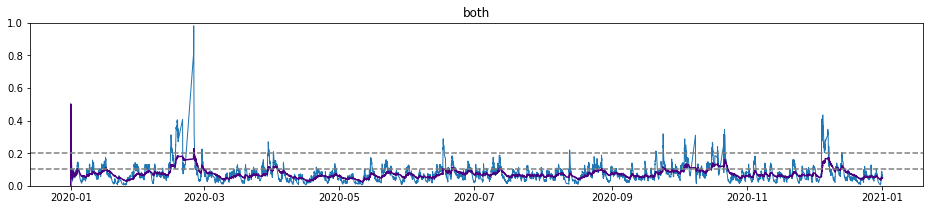

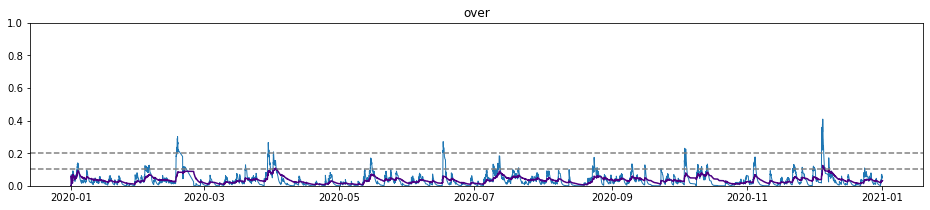

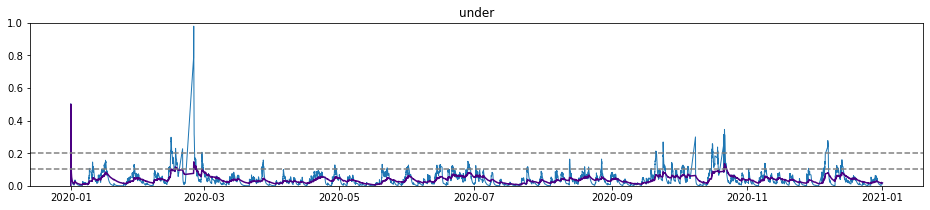

In [66]:
plot_EWMA(ewma_WTG12, 'both')
plot_EWMA(ewma_WTG12, 'over')
plot_EWMA(ewma_WTG12, 'under')